# Property Map Collective Variable Force Field Correction Pipeline
---
The pipeline generates force field corrections in .pdb format and is divided into these steps:

1. [Molecule shape processing](#1.-Molecule-shape-processing)
2. [Preparation of environment and molecule](#2.-Preparation-of-environment-and-molecule)
3. [Generation of representative configurations](#3.-Generation-of-representative-configurations)
4. [Accurate energy computation](#4.-Accurate-energy-computation)
5. [Inaccurate energy computation](#5.-Inaccurate-energy-computation)
6. [Define correction of force field](#6.-Define-correction-of-force-field)

In [1]:
import os
import re
import sys
import math
import time
import shutil
import subprocess

# import analytical software
from rdkit.Chem.Draw import IPythonConsole
from rdkit import Chem
from tqdm.notebook import tqdm
from molvs import Standardizer
import nglview as nv
import pytraj as pt
import matplotlib.pyplot as plt

# import custom libraries
from modules.draw_3d import drawit
from modules.k8s.k8s_run import gmx_run, orca_run, parmtsnecv_run, parallel_wait

# path to orca job result check script
orca_job_check = '/opt/orcajobcheck.py'

## 1. Molecule shape processing

In [40]:
# set visualization parameters
# ... add Indices to molecule image
IPythonConsole.drawOptions.addAtomIndices = True

# ... set molecule size
IPythonConsole.molSize = 900,900

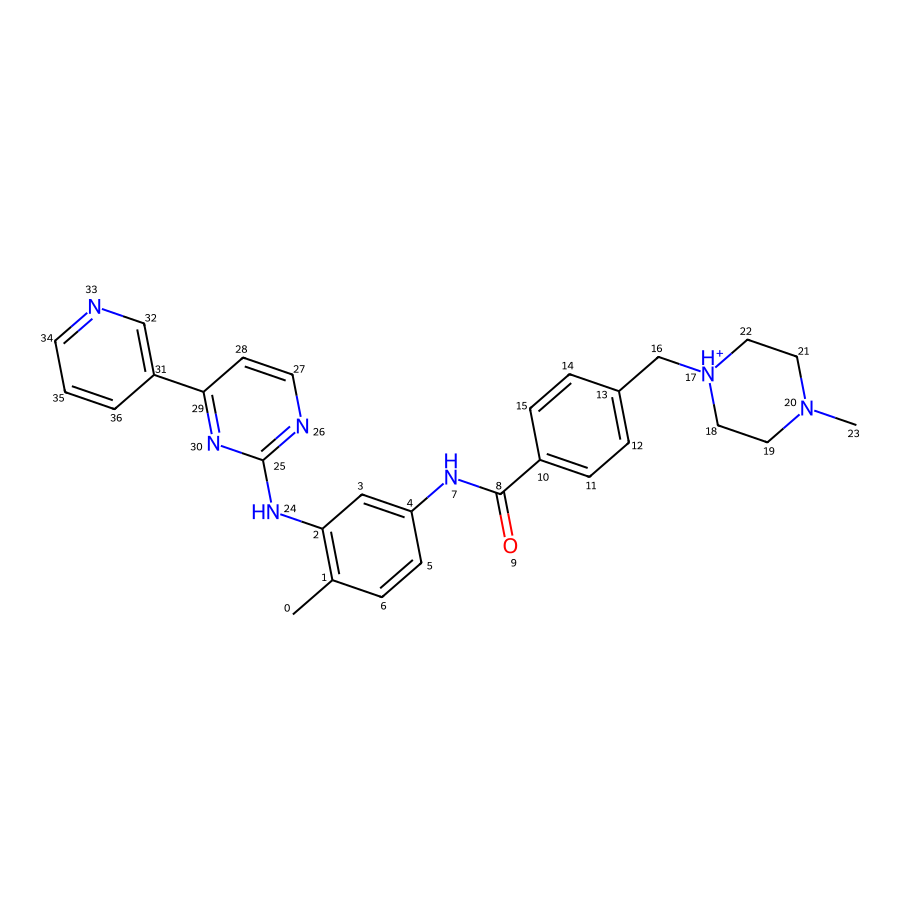

In [2]:
# specify input of desired molecule in SMILES
smiles_molecule = 'CC1=C(C=C(C=C1)NC(=O)C2=CC=C(C=C2)C[NH+]3CCN(CC3)C)NC4=NC=CC(=N4)C5=CN=CC=C5'


molecule = Chem.MolFromSmiles(smiles_molecule)
molecule

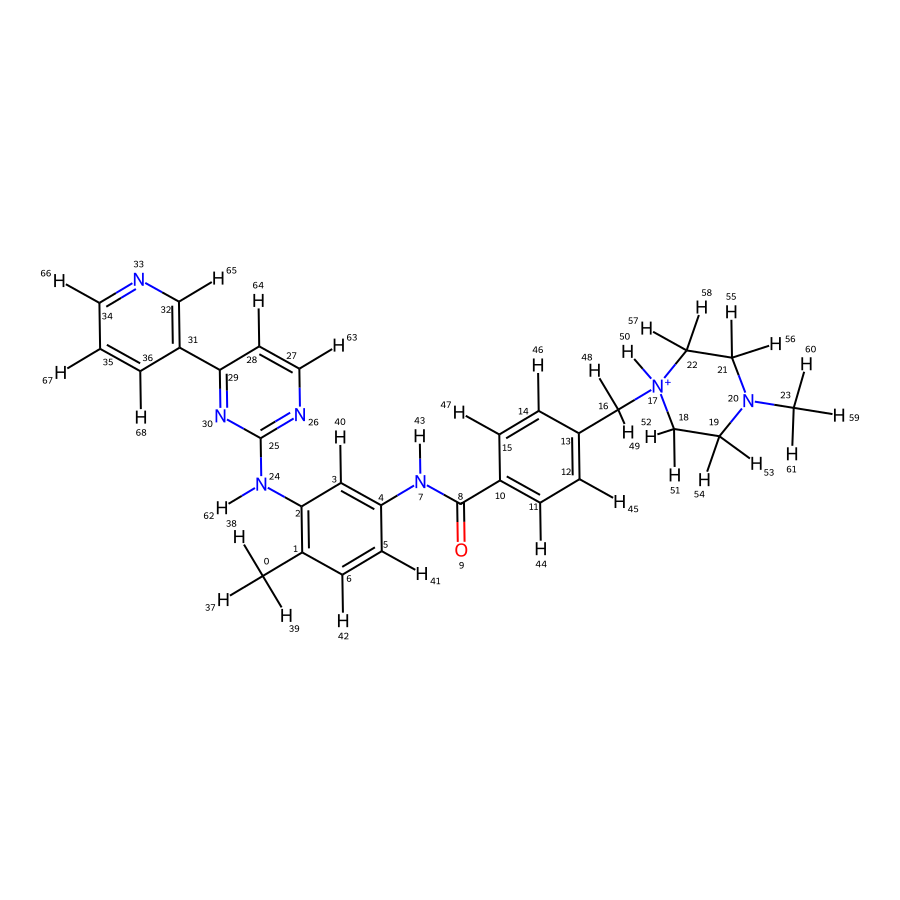

In [12]:
s = Standardizer()
molecule = s.standardize(molecule)
molecule = Chem.AddHs(molecule)
natoms = molecule.GetNumAtoms()
charge = Chem.rdmolops.GetFormalCharge(molecule)

molecule

### 1.1 Set the lowest energy configuration
Perform basic energy minimisation by running [Merck molecular force field (MMFF94)](https://open-babel.readthedocs.io/en/latest/Forcefields/mmff94.html) and choose the conformation with the lowest energy.

Visualize the configuration with lowest energy in 3D afterwards.

In [6]:
# number of configurations to generate
numc = 50

Chem.AllChem.EmbedMultipleConfs(molecule, clearConfs=True, numConfs=numc)

# run MMFF94
optim = Chem.AllChem.MMFFOptimizeMoleculeConfs(molecule)

minid = -1
minene = sys.float_info.max
for i in range(len(optim)):
    if optim[i][1] < minene:
        minene = optim[i][1]
        minid = i

# write to file molekula.mol for further processing
writer = Chem.SDWriter('molekula.mol')
writer.write(molecule, confId = minid)

drawit(molecule, confId = minid)

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [8]:
charge

1

### 1.2 Detect torsion angles
Detect torsions based on pattern in *smarts*. Output can be checked on 2D visualization in step [2. Molecule shape processing](#2.-Molecule-shape-processing).

In [7]:
bond_smarts = ''.join(('[!$([NH]!@C(=O))&!D1&!$(*#*)&!$([C;H3])&!$([O;H1])&!$([N;H3])]-&!@',
                       '[!$([NH]!@C(=O))&!D1&!$(*#*)&!$([C;H3])&!$([O;H1])&!$([N;H3])]'))

rotatable_bond = Chem.MolFromSmarts(bond_smarts)
rotatables = molecule.GetSubstructMatches(rotatable_bond)
print(f'Rotatables: {rotatables}')


torsions = []
for rotatable in rotatables:
    pairs1 = []
    pairs2 = []
    for bond in molecule.GetBonds():
        if rotatable[0] == bond.GetBeginAtomIdx() and rotatable[1] != bond.GetEndAtomIdx():
            pairs1.append([bond.GetBeginAtomIdx(), bond.GetEndAtomIdx()])
        if rotatable[1] == bond.GetBeginAtomIdx() and rotatable[0] != bond.GetEndAtomIdx():
            pairs2.append([bond.GetBeginAtomIdx(), bond.GetEndAtomIdx()])
    torsions.append([pairs1[0][1], pairs1[0][0], pairs2[0][0], pairs2[0][1]])
print(f'Torsions: {torsions}')

Rotatables: ((2, 24), (8, 10), (13, 16), (16, 17), (24, 25), (29, 31))
Torsions: [[3, 2, 24, 25], [9, 8, 10, 11], [14, 13, 16, 17], [48, 16, 17, 18], [62, 24, 25, 26], [30, 29, 31, 32]]


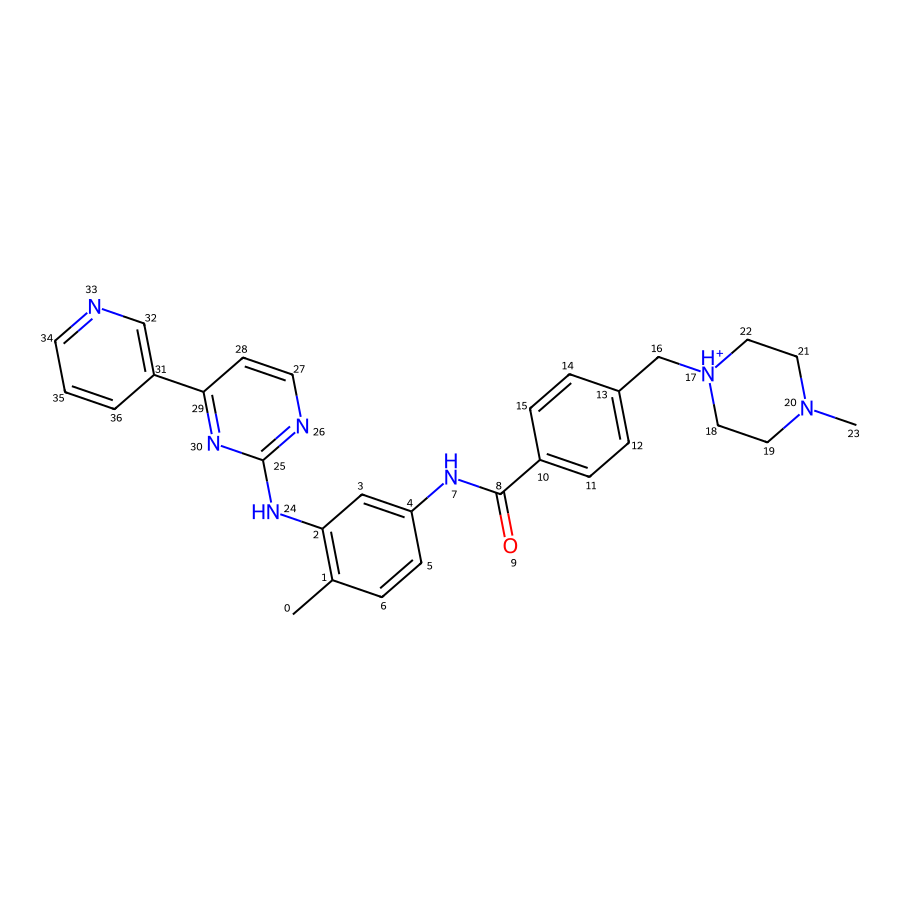

In [84]:
molecule

## 2. Preparation of environment and molecule
### 2.1 Perform energetic minimisation
Generate config file and other files needed for energetic minimisation. During generation an ordering of atoms will get wrong. This is fixed afterwards from output files to fit the minimised molecule.

Finally perform an energetic minimisation using [Gromacs](https://www.gromacs.org/). This pipeline uses wrapper so the Gromacs can be run independently to this environment. Please read the wrapper [documentation](https://github.com/CERIT-SC/pmcvff-correction/tree/jupyter-refactor/modules/k8s) before you interact with any Gromacs command.

In [ ]:
with open("em/em.mdp", "w") as emfile:
    lines = [
        'integrator          =  steep',
        'nsteps              =  100000',
        'emtol               =  0',
        'emstep              =  0.1',
        'nstcomm             =  1',
        'nstxout             =  100',
        'nstvout             =  100',
        'nstfout             =  0',
        'nstlog              =  100',
        'nstenergy           =  100',
        'nstlist             =  1',
        'ns_type             =  grid',
        'coulombtype         =  cut-off',
        'rlist               =  1.4',
        'rcoulomb            =  1.4',
        'rvdw                =  1.4',
        'energygrps          =  System',
        'epsilon-r           =  80'
    ]
    emfile.writelines(line + '\n' for line in lines)
    

!antechamber -i molekula.mol -fi mdl -o molekula.prepi -fo prepi -c bcc -nc {charge} && \
parmchk2 -i molekula.prepi -f prepi -o molekula.frcmod && \
tleap -f tleapin.txt && \
acpype -p molekula.prmtop -x molekula.inpcrd

shutil.copy("MOL.amb2gmx/MOL_GMX.gro", "em/")
shutil.copy("MOL.amb2gmx/MOL_GMX.top", "em/")


Welcome to antechamber 21.0: molecular input file processor.

acdoctor mode is on: check and diagnose problems in the input file.
The atom type is set to gaff; the options available to the -at flag are
    gaff, gaff2, amber, bcc, and sybyl.
-- Check Format for mdl File --
   Status: pass
-- Check Unusual Elements --
   Status: pass
-- Check Open Valences --
   Status: pass
-- Check Geometry --
      for those bonded   
      for those not bonded   
   Status: pass
-- Check Weird Bonds --
   Status: pass
-- Check Number of Units --
   Status: pass
acdoctor mode has completed checking the input file.

Info: Total number of electrons: 262; net charge: 1

Running: /opt/conda/envs/pyenv/bin/sqm -O -i sqm.in -o sqm.out


In [5]:
!python3.9 /opt/conda/envs/pyenv/bin/acpype -p auranofin.prmtop -x auranofin.inpcrd

| ACPYPE: AnteChamber PYthon Parser interfacE v. 2022.6.6 (c) 2023 AWSdS |
Converting Amber input files to Gromacs ...
==> Writing GROMACS files

==> Disambiguating lower and uppercase atomtypes in GMX top file, even if identical.

==> Writing GMX dihedrals for GMX 4.5 and higher.

Total time of execution: less than a second


In [3]:
v= nv.show_file('auranofin.amb2gmx/auranofin_GMX.gro')
v

NGLWidget()

In [2]:
t = pt.load('auranofin.amb2gmx/auranofin_GMX.gro',top='auranofin.amb2gmx/auranofin_GMX.top')

In [5]:
t.save('auranofin.pdb')

In [3]:
mol = Chem.RWMol(Chem.MolFromPDBFile('auranofin.pdb',removeHs=False))

In [4]:
#mol.AddBond(6,24)
#mol.AddBond(24,27)
mol.AddBond(10,43)
mol.AddBond(43,51)
Chem.SanitizeMol(mol,Chem.rdmolops.SanitizeFlags.SANITIZE_ALL)

rdkit.Chem.rdmolops.SanitizeFlags.SANITIZE_NONE

In [5]:
Chem.AllChem.Compute2DCoords(mol)

0

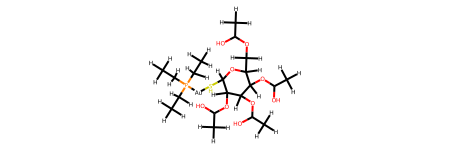

In [6]:
mol

In [ ]:
# fix ordering of atoms

order_before = []
with open('sqm.pdb','r') as pdbfile:
    for atom in pdbfile.readlines():
        order_before.append(atom.split()[2])
        
order_after = []
with open('MOL.amb2gmx/MOL_GMX.gro','r') as grofile:
    for atom in grofile.readlines():
        if atom.startswith('    1  MOL'):
            order_after.append(atom.split()[2])

            
torsions_new = []
torsion_new = []
for torsion in torsions:
    for i in torsion:       
        torsion_new.append(order_after.index(order_before[i])+1)
    torsions_new.append(torsion_new)
    torsion_new = []
    
torsions = torsions_new
print(f'New torsions: {torsions}')

In [24]:
!mkdir -p em
!cp auranofin.amb2gmx/auranofin_GMX.gro auranofin.amb2gmx/auranofin_GMX.top em/

In [3]:
gmx_run('editconf -f auranofin_GMX -o box -c -box 3 3 3', workdir='em')

job.batch/gromacs-editconf-rdtscp-16849216171315873 created


Waiting for job(s) with label gromacs-editconf-rdtscp-16849216171315873
Waiting for 1 jobs to complete
Using namespace mff-prod-ns


/gromacs/gmx-chooser.sh: line 39: grep: command not found
/gromacs/gmx-chooser.sh: line 41: grep: command not found
/usr/local/bin/gmx: line 12: basename: command not found
/usr/local/bin/gmx: line 12: [: =: unary operator expected
                 :-) GROMACS - gmx editconf, 2021-MODIFIED (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus      

In [4]:
gmx_run('grompp -f em.mdp -c box -p auranofin_GMX -o em1', workdir='em')

job.batch/gromacs-grompp-rdtscp-1684921647856007 created


Waiting for job(s) with label gromacs-grompp-rdtscp-1684921647856007
Waiting for 1 jobs to complete
Using namespace mff-prod-ns


/gromacs/gmx-chooser.sh: line 39: grep: command not found
/gromacs/gmx-chooser.sh: line 41: grep: command not found
/usr/local/bin/gmx: line 12: basename: command not found
/usr/local/bin/gmx: line 12: [: =: unary operator expected
                  :-) GROMACS - gmx grompp, 2021-MODIFIED (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus       

In [6]:
gmx_run('mdrun -deffnm em1', workdir='em')

job.batch/gromacs-mdrun-rdtscp-16849217428914146 created


Waiting for job(s) with label gromacs-mdrun-rdtscp-16849217428914146
Waiting for 1 jobs to complete
Using namespace mff-prod-ns


/gromacs/gmx-chooser.sh: line 39: grep: command not found
/gromacs/gmx-chooser.sh: line 41: grep: command not found
/usr/local/bin/gmx: line 12: basename: command not found
/usr/local/bin/gmx: line 12: [: =: unary operator expected
                   :-) GROMACS - gmx mdrun, 2021-MODIFIED (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus       

### 2.2 Perform molecular dynamics simulation
Create config file and perform molecular dynamics simulation. Simulation trajectory can be visualized.

Afterwards a [periodic boundary conditions](https://www.gromacs.org/Documentation_of_outdated_versions/Terminology/Periodic_Boundary_Conditions) must be applied so the molecule "does not jump out of the box". 

In [7]:
with open('md/md.mdp', 'w') as mdfile:
    lines = [
        'integrator          = sd',
        'nsteps              = 100000',
        'dt                  = 0.001',
        'nstxout             = 1000',
        'nstvout             = 1000',
        'nstenergy           = 1000',
        'nstlog              = 1000',
        'continuation        = no',
        'constraints         = none',
        'cutoff-scheme       = Verlet',
        'ns_type             = grid',
        'nstlist             = 1',
        'rlist               = 1.4',
        'rcoulomb            = 1.4',
        'rvdw                = 1.4',
        'coulombtype         = cut-off',
        'tcoupl              = V-rescale',
        'tc-grps             = system',
        'tau_t               = 0.1',
        'ref_t               = 300',
        'pcoupl              = no',
        'pbc                 = xyz',
        'gen_vel             = yes',
        'epsilon-r           = 80'
    ]
    mdfile.writelines(line + '\n' for line in lines)
    
shutil.copy('em/em1.gro', 'md/')
shutil.copy('auranofin.amb2gmx/auranofin_GMX.top', 'md/')

'md/auranofin_GMX.top'

In [8]:
gmx_run('grompp -f md.mdp -c em1 -p auranofin_GMX -o md1', workdir='md')

job.batch/gromacs-grompp-rdtscp-16849219035684283 created


Waiting for job(s) with label gromacs-grompp-rdtscp-16849219035684283
Waiting for 1 jobs to complete
Using namespace mff-prod-ns


/gromacs/gmx-chooser.sh: line 39: grep: command not found
/gromacs/gmx-chooser.sh: line 41: grep: command not found
/usr/local/bin/gmx: line 12: basename: command not found
/usr/local/bin/gmx: line 12: [: =: unary operator expected
                  :-) GROMACS - gmx grompp, 2021-MODIFIED (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus       

In [9]:
gmx_run('mdrun -deffnm md1', workdir='md')

job.batch/gromacs-mdrun-rdtscp-16849219244540222 created


Waiting for job(s) with label gromacs-mdrun-rdtscp-16849219244540222
Waiting for 1 jobs to complete
Using namespace mff-prod-ns


/gromacs/gmx-chooser.sh: line 39: grep: command not found
/gromacs/gmx-chooser.sh: line 41: grep: command not found
/usr/local/bin/gmx: line 12: basename: command not found
/usr/local/bin/gmx: line 12: [: =: unary operator expected
                   :-) GROMACS - gmx mdrun, 2021-MODIFIED (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus       

In [10]:
# convert trajectory to .pdb format so it can be visualized

# select group for trjconv evaluation output
# Group     0 (         System)
# Group     1 (          Other)
# Group     2 (            MOL)
group = '0'


gmx_run('trjconv -pbc nojump -s md1.tpr -f md1.trr -o outTraj.pdb', workdir='md', groups=group)

job.batch/gromacs-trjconv-rdtscp-16849220246196487 created


Waiting for job(s) with label gromacs-trjconv-rdtscp-16849220246196487
Waiting for 1 jobs to complete
Using namespace mff-prod-ns


/gromacs/gmx-chooser.sh: line 39: grep: command not found
/gromacs/gmx-chooser.sh: line 41: grep: command not found
/usr/local/bin/gmx: line 12: basename: command not found
/usr/local/bin/gmx: line 12: [: =: unary operator expected
                  :-) GROMACS - gmx trjconv, 2021-MODIFIED (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus      

In [11]:
# visualize the molecular dynamics trajectory
traj = pt.load('md/outTraj.pdb')
view = nv.show_pytraj(traj)
view

NGLWidget(max_frame=100)

In [30]:
#mol2 = Chem.MolFromSmiles(Chem.MolToSmiles(mol),sanitize=True)

In [31]:
#mol2.UpdatePropertyCache()

In [6]:
mol.GetRingInfo().NumRings()

1

In [7]:
bond_smarts = ''.join(('[!$([NH]!@C(=O))&!D1&!$(*#*)&!$([C;H3])&!$([O;H1])&!$([N;H3])]-&!@',
                       '[!$([NH]!@C(=O))&!D1&!$(*#*)&!$([C;H3])&!$([O;H1])&!$([N;H3])]'))

rotatable_bond = Chem.MolFromSmarts(bond_smarts)
rotatables = mol.GetSubstructMatches(rotatable_bond)
print(f'Rotatables: {rotatables}')

neigh = { a.GetIdx() : set() for a in mol.GetAtoms() }
for b in mol.GetBonds():
    if b.GetEndAtom().GetAtomicNum() > 1:
        neigh[b.GetBeginAtomIdx()].add(b.GetEndAtomIdx())
    if b.GetBeginAtom().GetAtomicNum() > 1:
        neigh[b.GetEndAtomIdx()].add(b.GetBeginAtomIdx())
    
    
torsions = [ ((neigh[r[0]]-{r[1]}).pop(), r[0], r[1], (neigh[r[1]]-{r[0]}).pop()) for r in rotatables]

print(f'Torsions: {torsions}')

Rotatables: ((1, 6), (6, 7), (9, 10), (13, 14), (14, 15), (15, 16), (25, 26), (26, 27), (34, 36), (36, 37), (48, 51), (51, 52), (51, 59))
Torsions: [(0, 1, 6, 7), (1, 6, 7, 9), (12, 9, 10, 43), (25, 13, 14, 15), (13, 14, 15, 16), (14, 15, 16, 17), (34, 25, 26, 27), (25, 26, 27, 28), (25, 34, 36, 37), (34, 36, 37, 42), (44, 48, 51, 59), (48, 51, 52, 53), (48, 51, 59, 62)]


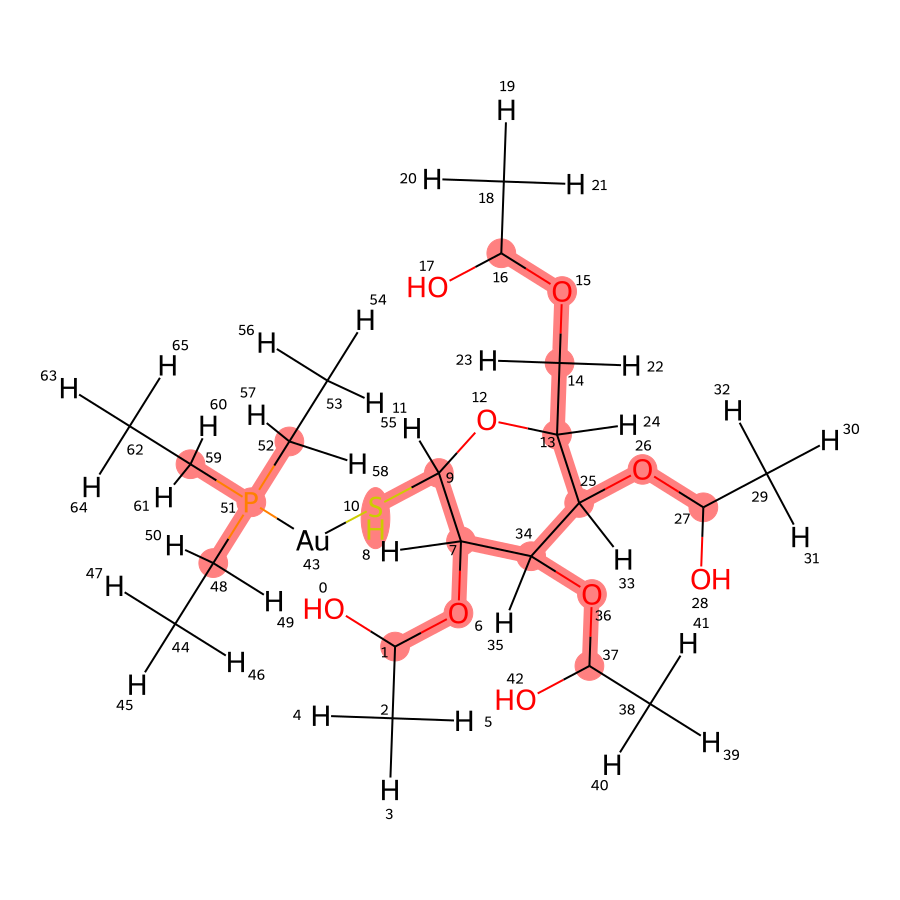

In [41]:
mol

In [9]:
# auranofin hack (can't do SMARTS now)
torsions.append((9,10,43,51))
torsions.append((10,43,51,52))
torsions

[(0, 1, 6, 7),
 (1, 6, 7, 9),
 (12, 9, 10, 43),
 (25, 13, 14, 15),
 (13, 14, 15, 16),
 (14, 15, 16, 17),
 (34, 25, 26, 27),
 (25, 26, 27, 28),
 (25, 34, 36, 37),
 (34, 36, 37, 42),
 (44, 48, 51, 59),
 (48, 51, 52, 53),
 (48, 51, 59, 62),
 (9, 10, 43, 51),
 (10, 43, 51, 52)]

In [119]:
# fix periodic boundaries errors 

# select group for trjconv evaluation output
# Group     0 (         System)
# Group     1 (          Other)
# Group     2 (            MOL)
group = '1'


for i in tqdm(range(len(torsions))):
    fr = str(float(100-len(torsions)+i)-0.01)
    to = str(float(100-len(torsions)+i)+0.01)
    gmx_run(f'trjconv -pbc nojump -s md1 -f md1 -o frame{i}.gro -b {fr} -e {to}<<EOF\n0\nEOF',
            workdir='md',
            groups=group)

  0%|          | 0/17 [00:00<?, ?it/s]

job.batch/gromacs-trjconv-rdtscp-16849292218825493 created


Waiting for job(s) with label gromacs-trjconv-rdtscp-16849292218825493
Waiting for 1 jobs to complete
Using namespace mff-prod-ns


/gromacs/gmx-chooser.sh: line 39: grep: command not found
/gromacs/gmx-chooser.sh: line 41: grep: command not found
/usr/local/bin/gmx: line 12: basename: command not found
/usr/local/bin/gmx: line 12: [: =: unary operator expected
                  :-) GROMACS - gmx trjconv, 2021-MODIFIED (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus      

Waiting for job(s) with label gromacs-trjconv-rdtscp-16849292307243245
Waiting for 1 jobs to complete
Using namespace mff-prod-ns


/gromacs/gmx-chooser.sh: line 39: grep: command not found
/gromacs/gmx-chooser.sh: line 41: grep: command not found
/usr/local/bin/gmx: line 12: basename: command not found
/usr/local/bin/gmx: line 12: [: =: unary operator expected
                  :-) GROMACS - gmx trjconv, 2021-MODIFIED (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus      

Waiting for job(s) with label gromacs-trjconv-rdtscp-16849292395299382
Waiting for 1 jobs to complete
Using namespace mff-prod-ns


/gromacs/gmx-chooser.sh: line 39: grep: command not found
/gromacs/gmx-chooser.sh: line 41: grep: command not found
/usr/local/bin/gmx: line 12: basename: command not found
/usr/local/bin/gmx: line 12: [: =: unary operator expected
                  :-) GROMACS - gmx trjconv, 2021-MODIFIED (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus      

Waiting for job(s) with label gromacs-trjconv-rdtscp-16849292486103687
Waiting for 1 jobs to complete
Using namespace mff-prod-ns


/gromacs/gmx-chooser.sh: line 39: grep: command not found
/gromacs/gmx-chooser.sh: line 41: grep: command not found
/usr/local/bin/gmx: line 12: basename: command not found
/usr/local/bin/gmx: line 12: [: =: unary operator expected
                  :-) GROMACS - gmx trjconv, 2021-MODIFIED (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus      

Waiting for job(s) with label gromacs-trjconv-rdtscp-16849292573030658
Waiting for 1 jobs to complete
Using namespace mff-prod-ns


/gromacs/gmx-chooser.sh: line 39: grep: command not found
/gromacs/gmx-chooser.sh: line 41: grep: command not found
/usr/local/bin/gmx: line 12: basename: command not found
/usr/local/bin/gmx: line 12: [: =: unary operator expected
                  :-) GROMACS - gmx trjconv, 2021-MODIFIED (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus      

Waiting for job(s) with label gromacs-trjconv-rdtscp-16849292660320332
Waiting for 1 jobs to complete
Using namespace mff-prod-ns


/gromacs/gmx-chooser.sh: line 39: grep: command not found
/gromacs/gmx-chooser.sh: line 41: grep: command not found
/usr/local/bin/gmx: line 12: basename: command not found
/usr/local/bin/gmx: line 12: [: =: unary operator expected
                  :-) GROMACS - gmx trjconv, 2021-MODIFIED (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus      

Waiting for job(s) with label gromacs-trjconv-rdtscp-16849292749498684
Waiting for 1 jobs to complete
Using namespace mff-prod-ns


/gromacs/gmx-chooser.sh: line 39: grep: command not found
/gromacs/gmx-chooser.sh: line 41: grep: command not found
/usr/local/bin/gmx: line 12: basename: command not found
/usr/local/bin/gmx: line 12: [: =: unary operator expected
                  :-) GROMACS - gmx trjconv, 2021-MODIFIED (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus      

Waiting for job(s) with label gromacs-trjconv-rdtscp-16849292833088875
Waiting for 1 jobs to complete
Using namespace mff-prod-ns


/gromacs/gmx-chooser.sh: line 39: grep: command not found
/gromacs/gmx-chooser.sh: line 41: grep: command not found
/usr/local/bin/gmx: line 12: basename: command not found
/usr/local/bin/gmx: line 12: [: =: unary operator expected
                  :-) GROMACS - gmx trjconv, 2021-MODIFIED (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus      

Waiting for job(s) with label gromacs-trjconv-rdtscp-16849292920164347
Waiting for 1 jobs to complete
Using namespace mff-prod-ns


/gromacs/gmx-chooser.sh: line 39: grep: command not found
/gromacs/gmx-chooser.sh: line 41: grep: command not found
/usr/local/bin/gmx: line 12: basename: command not found
/usr/local/bin/gmx: line 12: [: =: unary operator expected
                  :-) GROMACS - gmx trjconv, 2021-MODIFIED (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus      

Waiting for job(s) with label gromacs-trjconv-rdtscp-16849293005604088
Waiting for 1 jobs to complete
Using namespace mff-prod-ns


/gromacs/gmx-chooser.sh: line 39: grep: command not found
/gromacs/gmx-chooser.sh: line 41: grep: command not found
/usr/local/bin/gmx: line 12: basename: command not found
/usr/local/bin/gmx: line 12: [: =: unary operator expected
                  :-) GROMACS - gmx trjconv, 2021-MODIFIED (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus      

Waiting for job(s) with label gromacs-trjconv-rdtscp-1684929334407059
Waiting for 1 jobs to complete
Using namespace mff-prod-ns


/gromacs/gmx-chooser.sh: line 39: grep: command not found
/gromacs/gmx-chooser.sh: line 41: grep: command not found
/usr/local/bin/gmx: line 12: basename: command not found
/usr/local/bin/gmx: line 12: [: =: unary operator expected
                  :-) GROMACS - gmx trjconv, 2021-MODIFIED (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus      

Waiting for job(s) with label gromacs-trjconv-rdtscp-1684929343207984
Waiting for 1 jobs to complete
Using namespace mff-prod-ns


/gromacs/gmx-chooser.sh: line 39: grep: command not found
/gromacs/gmx-chooser.sh: line 41: grep: command not found
/usr/local/bin/gmx: line 12: basename: command not found
/usr/local/bin/gmx: line 12: [: =: unary operator expected
                  :-) GROMACS - gmx trjconv, 2021-MODIFIED (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus      

Waiting for job(s) with label gromacs-trjconv-rdtscp-16849293523444698
Waiting for 1 jobs to complete
Using namespace mff-prod-ns


/gromacs/gmx-chooser.sh: line 39: grep: command not found
/gromacs/gmx-chooser.sh: line 41: grep: command not found
/usr/local/bin/gmx: line 12: basename: command not found
/usr/local/bin/gmx: line 12: [: =: unary operator expected
                  :-) GROMACS - gmx trjconv, 2021-MODIFIED (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus      

Waiting for job(s) with label gromacs-trjconv-rdtscp-16849293615374725
Waiting for 1 jobs to complete
Using namespace mff-prod-ns


/gromacs/gmx-chooser.sh: line 39: grep: command not found
/gromacs/gmx-chooser.sh: line 41: grep: command not found
/usr/local/bin/gmx: line 12: basename: command not found
/usr/local/bin/gmx: line 12: [: =: unary operator expected
                  :-) GROMACS - gmx trjconv, 2021-MODIFIED (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus      

Waiting for job(s) with label gromacs-trjconv-rdtscp-16849293702202504
Waiting for 1 jobs to complete
Using namespace mff-prod-ns


/gromacs/gmx-chooser.sh: line 39: grep: command not found
/gromacs/gmx-chooser.sh: line 41: grep: command not found
/usr/local/bin/gmx: line 12: basename: command not found
/usr/local/bin/gmx: line 12: [: =: unary operator expected
                  :-) GROMACS - gmx trjconv, 2021-MODIFIED (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus      

Waiting for job(s) with label gromacs-trjconv-rdtscp-16849293786512282
Waiting for 1 jobs to complete
Using namespace mff-prod-ns


/gromacs/gmx-chooser.sh: line 39: grep: command not found
/gromacs/gmx-chooser.sh: line 41: grep: command not found
/usr/local/bin/gmx: line 12: basename: command not found
/usr/local/bin/gmx: line 12: [: =: unary operator expected
                  :-) GROMACS - gmx trjconv, 2021-MODIFIED (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus      

Waiting for job(s) with label gromacs-trjconv-rdtscp-16849293877024112
Waiting for 1 jobs to complete
Using namespace mff-prod-ns


/gromacs/gmx-chooser.sh: line 39: grep: command not found
/gromacs/gmx-chooser.sh: line 41: grep: command not found
/usr/local/bin/gmx: line 12: basename: command not found
/usr/local/bin/gmx: line 12: [: =: unary operator expected
                  :-) GROMACS - gmx trjconv, 2021-MODIFIED (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus      

## 3. Generation of representative configurations
### 3.1 Trajectory generation
Create config file and *plumed.dat* file. Based on these files run the simulation (with metadynamics) to generate a trajectory.

[Plumed](https://www.plumed.org/) is used to run metadynamics.

In [120]:
with open('mtd/mtd.mdp', 'w') as mtdfile:
    lines = [
        'integrator          = sd',
        'nsteps              = 10000000',
        'dt                  = 0.001',
        'nstxout             = 10000',
        'nstvout             = 10000',
        'nstenergy           = 1000',
        'nstlog              = 1000',
        'continuation        = no',
        'constraints         = none',
        'cutoff-scheme       = Verlet',
        'ns_type             = grid',
        'nstlist             = 1',
        'rlist               = 1.4',
        'rcoulomb            = 1.4',
        'rvdw                = 1.4',
        'coulombtype         = cut-off',
        'tcoupl              = V-rescale',
        'tc-grps             = system',
        'tau_t               = 0.1',
        'ref_t               = 300',
        'pcoupl              = no',
        'pbc                 = xyz',
        'gen_vel             = yes',
        'epsilon-r           = 80'
    ]
    mtdfile.writelines(line + '\n' for line in lines)

In [10]:
natoms=len(mol.GetAtoms())

In [132]:
for i in range(len(torsions)):
    if not os.path.exists(f'mtd/w{i}'):
        os.mkdir(f'mtd/w{i}')
        
    with open(f'mtd/w{i}/plumed.dat', "w") as plumeddat:
        plumeddat.write('RANDOM_EXCHANGES\n' +
                       f'WHOLEMOLECULES ENTITY0=1-{natoms}\n')
        for j in range(len(torsions)):
            line = f"TORSION ATOMS={','.join([str(a+1) for a in torsions[j]])} LABEL=cv{j+1}\n"
            plumeddat.write(line)
        line = ' '.join((f'METAD ARG=cv{i+1} HEIGHT=0.5 SIGMA=0.3 PACE=1000 GRID_MIN=-pi',
                         'GRID_MAX=pi BIASFACTOR=15 LABEL=be\n'))
        plumeddat.write(line)
        cvs = ""
        for j in range(len(torsions)):
            cvs = cvs + f'cv{j+1},'
        cvs = cvs[:-1]
        plumeddat.write(f'PRINT ARG={cvs} STRIDE=1000 FILE=COLVAR\n' +
                         'PRINT ARG=be.bias STRIDE=1000 FILE=BIAS\n')

In [11]:
# XXX: uff
from modules.k8s.config import Config as k8config
!cp {k8config.PICKLE_PATH}/lock.pkl /tmp
k8config.PICKLE_PATH = '/tmp'

In [141]:
shutil.copy('auranofin.amb2gmx/auranofin_GMX.top', 'mtd/')

# perform preprocessing before generation of the trajectory
for i in tqdm(range(len(torsions))):
    shutil.copy(f'md/frame{i}.gro', f'mtd/w{i}/')
    gmx_run(f'grompp -f mtd.mdp -c w{i}/frame{i} -p auranofin_GMX -o w{i}/mtd1',
            workdir='mtd',
            parallel=True)
parallel_wait()

  0%|          | 0/17 [00:00<?, ?it/s]

job.batch/gromacs-grompp-rdtscp-16849309585984318 created
None
job.batch/gromacs-grompp-rdtscp-16849309601258514 created
None
job.batch/gromacs-grompp-rdtscp-16849309615371628 created
None
job.batch/gromacs-grompp-rdtscp-16849309627474256 created
None
job.batch/gromacs-grompp-rdtscp-16849309643334992 created
None
job.batch/gromacs-grompp-rdtscp-16849309658427906 created
None
job.batch/gromacs-grompp-rdtscp-16849309674324687 created
None
job.batch/gromacs-grompp-rdtscp-16849309688099926 created
None
job.batch/gromacs-grompp-rdtscp-16849309700333092 created
None
job.batch/gromacs-grompp-rdtscp-16849309714463289 created
None
job.batch/gromacs-grompp-rdtscp-16849309729334247 created
None
job.batch/gromacs-grompp-rdtscp-16849309744271042 created
None
job.batch/gromacs-grompp-rdtscp-16849309755936224 created
None
job.batch/gromacs-grompp-rdtscp-16849309769169924 created
None
job.batch/gromacs-grompp-rdtscp-16849309786257358 created
None
job.batch/gromacs-grompp-rdtscp-1684930979820174 create

Waiting for job(s) with label gromacs-grompp-rdtscp-16849309585984318
Waiting for 17 jobs to complete
Using namespace mff-prod-ns


/gromacs/gmx-chooser.sh: line 39: grep: command not found
/gromacs/gmx-chooser.sh: line 41: grep: command not found
/usr/local/bin/gmx: line 12: basename: command not found
/usr/local/bin/gmx: line 12: [: =: unary operator expected
                  :-) GROMACS - gmx grompp, 2021-MODIFIED (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus       

In [ ]:
directories = ''
for i in range(len(torsions)):
    directories = directories + f'w{i} '

# see mdrunlog in mtd directory for insight into running 
# mdrun simulation (e.g 'tail -f mdrunlog')
gmx_run(f'mdrun -g mdrunlog -deffnm mtd1 -replex 500 -plumed plumed.dat -multidir {directories}', 
        workdir='mtd', 
        mpi_run=len(torsions))

job.batch/gromacs-mdrun-rdtscp-16849311809275584 created


Waiting for job(s) with label gromacs-mdrun-rdtscp-16849311809275584
Waiting for 1 jobs to complete
Using namespace mff-prod-ns


### 3.2 Configurations clustering
Concatinate all the trajectories that simulation produced. Then cluster this trajectory to groups for which one representative configuration is chosen (*cutoff* can be modified for more/less clusters).

Result of [Gromacs clustering](https://manual.gromacs.org/documentation/current/onlinehelp/gmx-cluster.html) is .pdb file containing all representative configurations. These must be divided into separate .pdb files for further processing.

In [ ]:
trajectories = ''
for i in range(len(torsions)):
    trajectories = trajectories + f'mtd/w{i}/mtd1.trr '

# concatinate trajectories    
gmx_run(f'trjcat -f {trajectories} -cat -o mtd/mtd1.trr')

# make index file with non-hydrogen atoms
gmx_run("make_ndx -f md/md1.tpr -o mtd/index.ndx", make_ndx="1&!aH*")

In [11]:
# select groups for cluster evaluation output
# Group     0 (         System)
# Group     1 (          Other)
# Group     2 (            MOL)
# Group     3 (         Custom)

groups = '50'
#groups = '30'

gmx_run('''cluster -method gromos -f mtd/mtd1.trr -s mtd/w0/mtd1.tpr -n mtd/index.ndx -cutoff 0.15 \
           -cl clustering/outClusters.pdb''', groups=groups)

job.batch/gromacs-cluster-rdtscp-16850024106140513 created


Waiting for job(s) with label gromacs-cluster-rdtscp-16850024106140513
Waiting for 1 jobs to complete
Using namespace mff-prod-ns


/gromacs/gmx-chooser.sh: line 39: grep: command not found
/gromacs/gmx-chooser.sh: line 41: grep: command not found
/usr/local/bin/gmx: line 12: basename: command not found
/usr/local/bin/gmx: line 12: [: =: unary operator expected
                  :-) GROMACS - gmx cluster, 2021-MODIFIED (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus      

In [12]:
# divide all clusters from clustering output file 
# to single files and index them from 0.
# Also fix missing element of each ATOM on 
# line 77 (by pdb format specification)
cluster_index = 0
i = 0

with open('clustering/outClusters.pdb') as infile:
    clusters = infile.readlines()
    while i < len(clusters):
        with open(f'clustering/outClustersPDB/outCluster{cluster_index}.pdb', 'w') as outfile:
            for line in clusters[i:]:
                split_line = line.split()
                if split_line[0] == 'ATOM':
                    line = line[:77] + split_line[2][0] + '\n'
                outfile.write(line)
                i += 1
                if line == 'ENDMDL\n':
                    break
            cluster_index += 1

### 3.3 Visualize landmarks
Goal of this part is to compute embeddings which are visualized afterwards. Each step is performed on the trajectory which results from previous step. Base trajectory used in 1st step is the concatinated trajectory from metadynamics simulation.

1. Apply periodic boundary conditions to metadynamics trajectory
2. Perform fitting on the trajectory
3. Remove Hydrogen
4. Train [parmtSNEcv](https://gitlab.ics.muni.cz/spiwokv/parmtSNEcv)
5. Compute embeddings

Finally visualize all generated configurations from metadynamics trajectory in contrast to representative clusters configurations

In [14]:
# Group     0 (         System)
# Group     1 (          Other)
# Group     2 (            MOL)
# Group     3 (         Custom)
# select group for periodic boundaries check output:
group = '0'
gmx_run('trjconv -f mtd/mtd1.trr -s mtd/w0/mtd1.tpr -pbc mol -o visualization/traj/mtd1_nopbc.xtc', groups=group)

job.batch/gromacs-trjconv-rdtscp-16850027982995367 created


Waiting for job(s) with label gromacs-trjconv-rdtscp-16850027982995367
Waiting for 1 jobs to complete
Using namespace mff-prod-ns


/gromacs/gmx-chooser.sh: line 39: grep: command not found
/gromacs/gmx-chooser.sh: line 41: grep: command not found
/usr/local/bin/gmx: line 12: basename: command not found
/usr/local/bin/gmx: line 12: [: =: unary operator expected
                  :-) GROMACS - gmx trjconv, 2021-MODIFIED (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus      

In [16]:
# select groups for fitting and output:
groups = '00'
#gmx_run('''trjconv -f visualization/traj/mtd1_nopbc.xtc -s clustering/outClustersPDB/outCluster0.pdb \

gmx_run('''trjconv -f visualization/traj/mtd1_nopbc.xtc -s mtd/w0/mtd1.tpr \
           -fit rot+trans -o visualization/traj/mtd1_fit.xtc''', groups=groups)

job.batch/gromacs-trjconv-rdtscp-16850029143443186 created


Waiting for job(s) with label gromacs-trjconv-rdtscp-16850029143443186
Waiting for 1 jobs to complete
Using namespace mff-prod-ns


/gromacs/gmx-chooser.sh: line 39: grep: command not found
/gromacs/gmx-chooser.sh: line 41: grep: command not found
/usr/local/bin/gmx: line 12: basename: command not found
/usr/local/bin/gmx: line 12: [: =: unary operator expected
                  :-) GROMACS - gmx trjconv, 2021-MODIFIED (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus      

In [17]:
# select group for no Hydrogen output:
#group = '3'
group = '5'
gmx_run('trjconv -f visualization/traj/mtd1_fit.xtc -n mtd/index.ndx -o visualization/traj/mtd1_fit_noH.xtc',
        groups=group)

job.batch/gromacs-trjconv-rdtscp-16850029731425672 created


Waiting for job(s) with label gromacs-trjconv-rdtscp-16850029731425672
Waiting for 1 jobs to complete
Using namespace mff-prod-ns


/gromacs/gmx-chooser.sh: line 39: grep: command not found
/gromacs/gmx-chooser.sh: line 41: grep: command not found
/usr/local/bin/gmx: line 12: basename: command not found
/usr/local/bin/gmx: line 12: [: =: unary operator expected
                  :-) GROMACS - gmx trjconv, 2021-MODIFIED (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus      

In [18]:
# select groups for size of the box and output:
#groups = '33'
groups = '55'
gmx_run('''editconf -f clustering/outClustersPDB/outCluster0.pdb -n mtd/index.ndx -box 3 3 3 -c \
           -o visualization/ref.pdb''', groups=groups)

job.batch/gromacs-editconf-rdtscp-16850030007599847 created


Waiting for job(s) with label gromacs-editconf-rdtscp-16850030007599847
Waiting for 1 jobs to complete
Using namespace mff-prod-ns


/gromacs/gmx-chooser.sh: line 39: grep: command not found
/gromacs/gmx-chooser.sh: line 41: grep: command not found
/usr/local/bin/gmx: line 12: basename: command not found
/usr/local/bin/gmx: line 12: [: =: unary operator expected
                 :-) GROMACS - gmx editconf, 2021-MODIFIED (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus      

In [19]:
# fix weights of atoms
data = ''
with open('visualization/ref.pdb', 'r') as infile:
    data = infile.read()
    data = data.replace('0.00', '1.00')
with open('visualization/ref.pdb', 'w') as outfile:
    outfile.writelines(data)

In [21]:
# train parmtSNEcv
parmtsnecv_run('''parmtSNEcv -i traj/mtd1_fit_noH.xtc -p ref.pdb -boxx 3 -boxy 3 -boxz 3 \
               -dim 2 -layers 2 -o out.txt -plumed plumed.dat -epochs 500''', workdir='visualization')
#               -dim 2 -layers 2 -o out.txt -plumed plumed.dat -epochs 2000''', workdir='visualization')

job.batch/parmtsnecv-parmtsnecv-rdtscp-16850046099589243 created


Waiting for job(s) with label parmtsnecv-parmtsnecv-rdtscp-16850046099589243
Waiting for 1 jobs to complete
Using namespace mff-prod-ns


Using TensorFlow backend.
2023-05-25 08:50:33.749649: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2023-05-25 08:50:33.772816: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2794845000 Hz
2023-05-25 08:50:33.776875: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x564e564aad20 executing computations on platform Host. Devices:
2023-05-25 08:50:33.776900: I tensorflow/compiler/xla/service/service.cc:175]   StreamExecutor device (0): Host, Default Version
Loading trajectory
Fitting trajectory
<mdtraj.Trajectory with 3420 frames, 32 atoms, 3 residues, and unitcells> succesfully loaded and fitted

box size set to  3.000 x  3.000 x  3.000 nm

Building model
Training model
Computing pairwise distances...
Computing P-values for point 0 of 3420...
Computing P-values for point 500 of 3420...
Computing P-values for point 1000 of 3420...
Computing P-values f

In [22]:
# modify plumed.dat to compute embedding in every step (100->1) 
# and change the name of file for *** mtd trajectory ***
with open('visualization/plumed.dat', 'r') as infile:
    data = infile.read()
    data = data.replace('STRIDE=100', 'STRIDE=1')
    data = data.replace('COLVAR', '2d_embedding')
with open('visualization/plumed.dat', 'w') as outfile:
    outfile.writelines(data)

In [23]:
# run with plumed
gmx_run('driver --plumed plumed.dat --mf_xtc traj/mtd1_fit.xtc', workdir='visualization')

job.batch/gromacs-driver-rdtscp-16850052602427325 created


Waiting for job(s) with label gromacs-driver-rdtscp-16850052602427325
Waiting for 1 jobs to complete
Using namespace mff-prod-ns
IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [24]:
# modify plumed.dat to compute embedding in every step and change name of file for *** representatives ***
with open('visualization/plumed.dat', 'r') as infile:
    data = infile.read()
    data = data.replace('2d_embedding', 'landmarks')
with open('visualization/plumed.dat', 'w') as outfile:
    outfile.writelines(data)

In [25]:
# run with plumed
shutil.copy('clustering/outClusters.pdb', 'visualization/')
gmx_run('driver --plumed plumed.dat --mf_pdb outClusters.pdb', workdir='visualization')

job.batch/gromacs-driver-rdtscp-16850053915480745 created


Waiting for job(s) with label gromacs-driver-rdtscp-16850053915480745
Waiting for 1 jobs to complete
Using namespace mff-prod-ns
IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



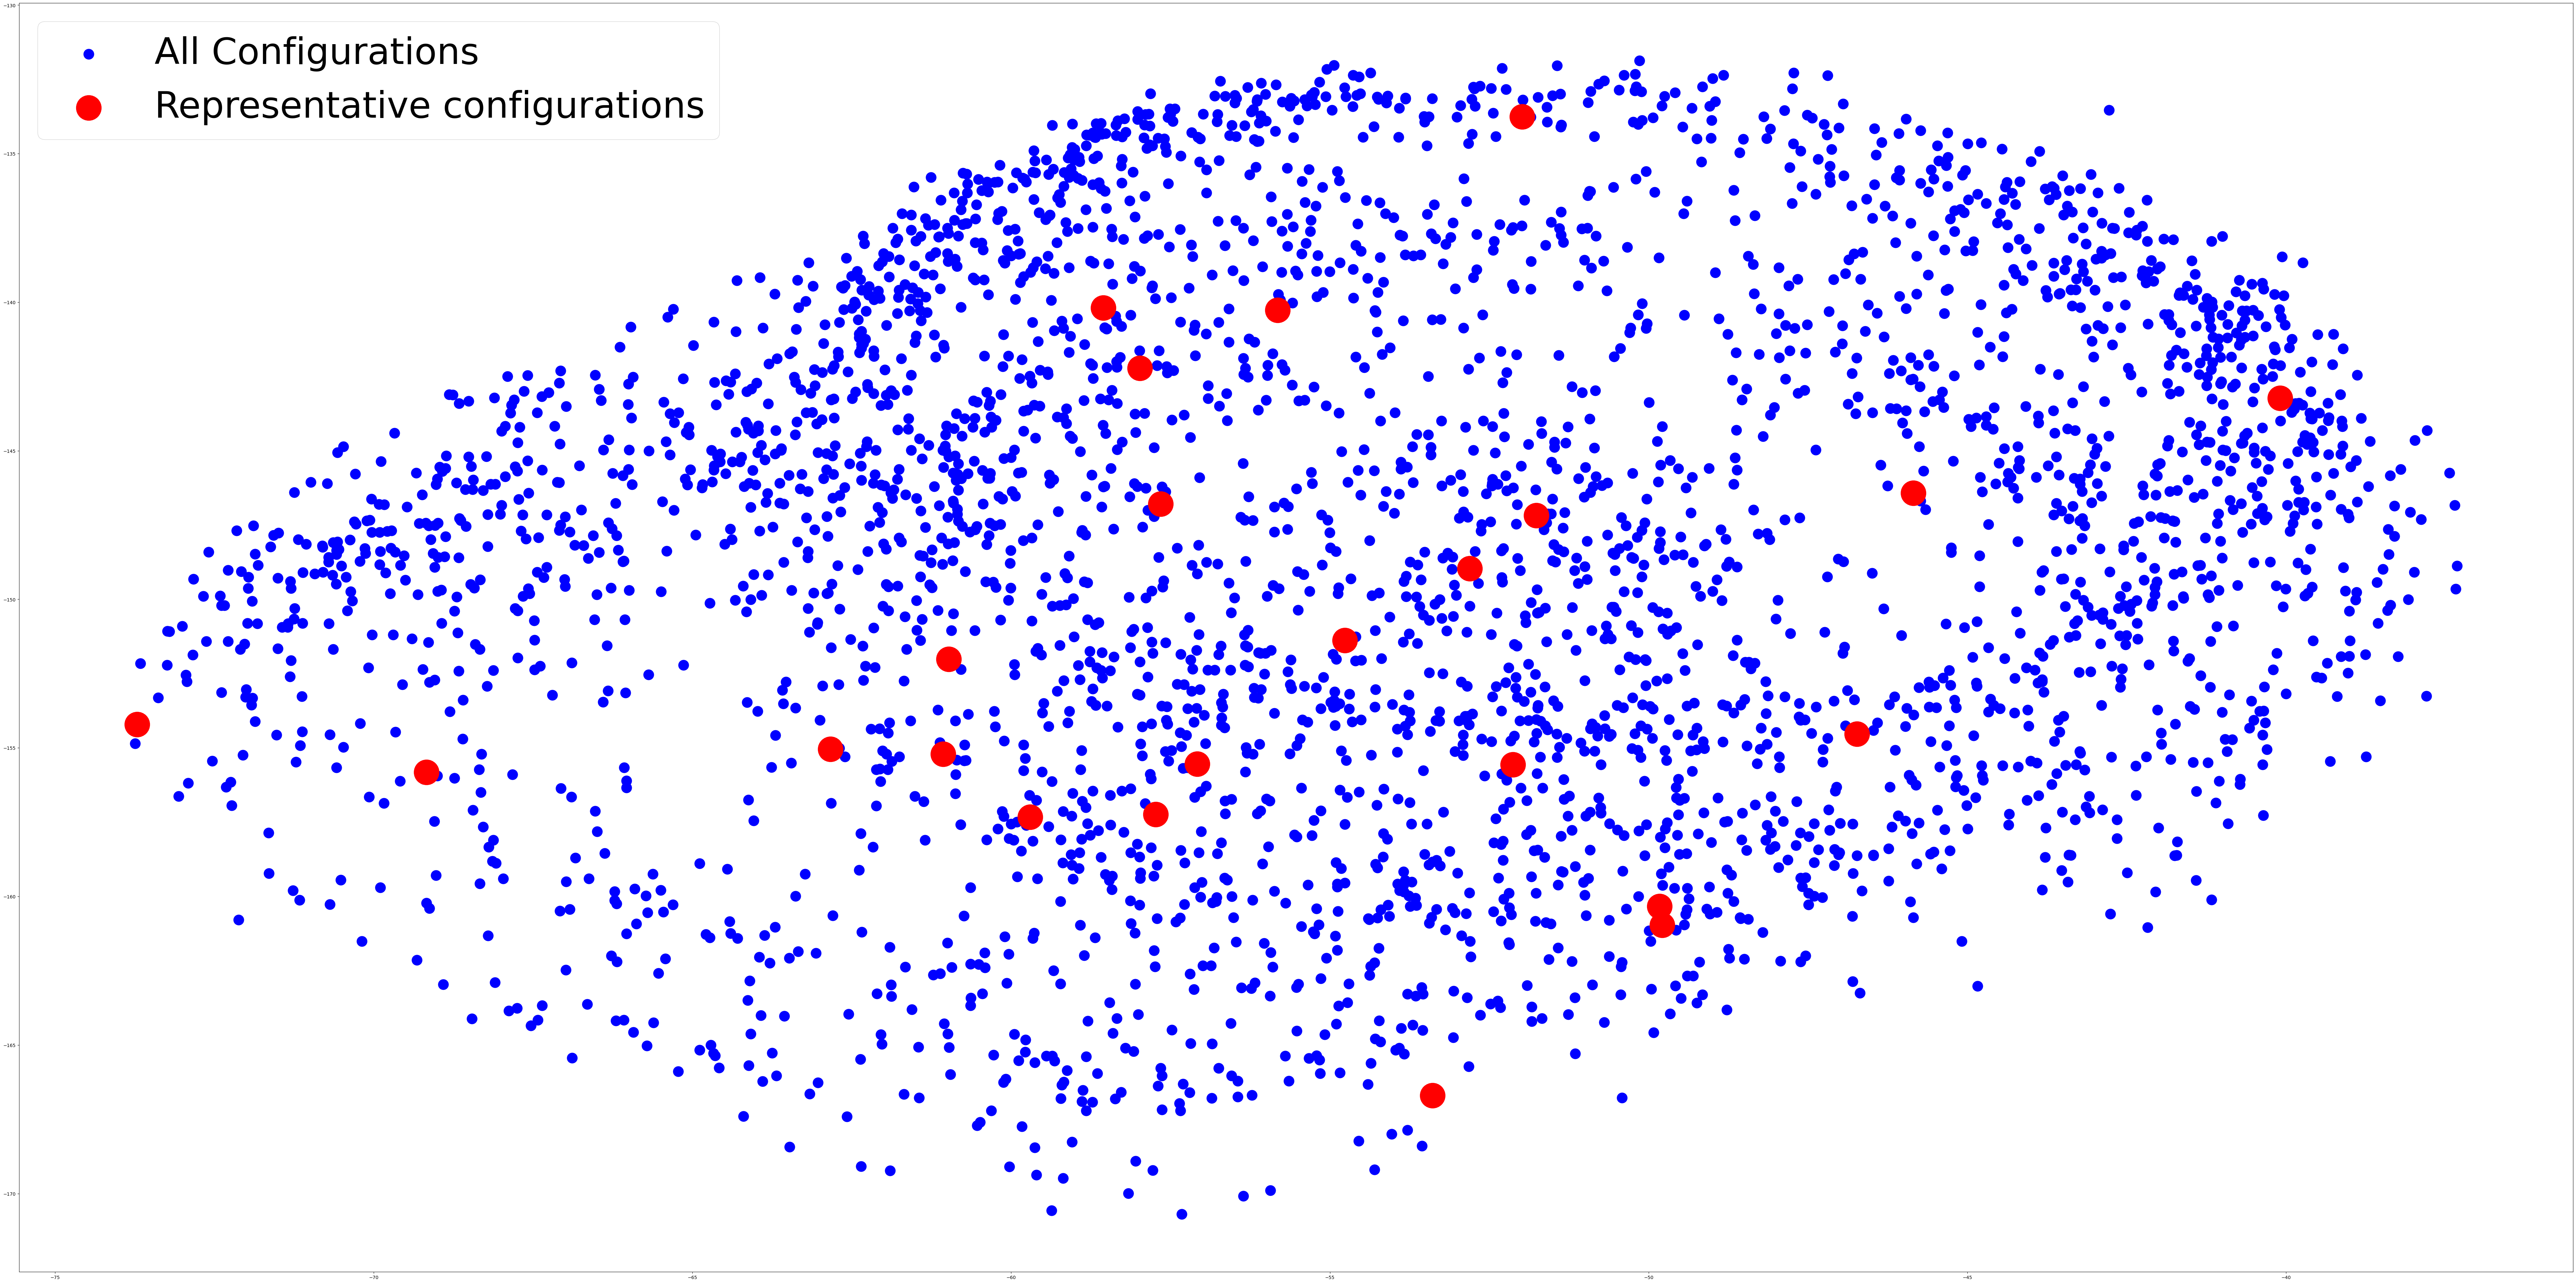

In [26]:
# visualize configurations in contrast to representative configurations

x = []
y = []
x1 = []
y1 = []
with open("visualization/2d_embedding", "r") as infile:
    for line in infile.readlines()[1:]:
        split_values = line.split()
        x.append(float(split_values[1]))
        y.append(float(split_values[2]))
with open("visualization/landmarks", "r") as infile:
    for line in infile.readlines()[1:]:
        split_values = line.split()
        x1.append(float(split_values[1]))
        y1.append(float(split_values[2]))
        
        
plt.figure(figsize=(100, 50), dpi=100)
plt.scatter(x, y, c='b', marker='.', label='All Configurations', s=2000)
plt.scatter(x1, y1, c='r', marker='o', label='Representative configurations', s=3000)
plt.legend(loc='upper left', prop={'size': 80})

plt.show()

## 4. Accurate energy computation
**Accurate energy** values are computed in this step using the [Orca](https://sites.google.com/site/orcainputlibrary/) quantum chemistry software. Orca uses [method files](https://sites.google.com/site/orcainputlibrary/generalinput) in exact format to perform the computations. Computation of exact energy values of each representative is composed of 3-step chain. Input for *AM1* are representative configurations defined by clustering in previous step. Each next computation is performed on the output of the previous step.

1. **AM1 optimisation** (*input*: clustering results)
2. **BP86 SVP** (*input*: AM1 output)
3. **BP86 TZVP** (*input*: BP86 SVP output, *output*: exact energy values of representative configurations)

Also each step above consists of 3 substeps:

1. Convert the output of previous step to Orca compatible *.inp method*
2. Perform Orca computation
3. Analyse output (see logs)

You can view the current state of Orca calculation in output logs (3rd substep) with for example *\"tail -f XXX\"* command. Please read the wrapper [documentation](https://github.com/CERIT-SC/pmcvff-correction/tree/jupyter-refactor/modules/k8s) before interacting with any Orca command.

In [10]:
torsions

[(0, 1, 6, 7),
 (1, 6, 7, 9),
 (12, 9, 10, 43),
 (25, 13, 14, 15),
 (13, 14, 15, 16),
 (14, 15, 16, 17),
 (34, 25, 26, 27),
 (25, 26, 27, 28),
 (25, 34, 36, 37),
 (34, 36, 37, 42),
 (44, 48, 51, 59),
 (48, 51, 52, 53),
 (48, 51, 59, 62),
 (9, 10, 43, 51),
 (10, 43, 51, 52)]

In [ ]:
# !!! not for auranofin

# fix indexing of atoms because Orca indexes from zero 
orca_torsions = [[] for _ in range(len(torsions))]
torsion_index = 0
for torsion in torsions:
    for atom_index in torsion:
        orca_torsions[torsion_index].append(atom_index - 1)
    torsion_index += 1
torsions = orca_torsions

In [37]:
# initialize a list of all clusters that are considered
# in the quantum chemistry computations. For example
# non-converged simulation on cluster will result in
# discarding that cluster from further computations
#
# ** don't forget to reset clusters variable when
# rerunning computations as non-converged will be
# missing **
clusters = []
for cluster in os.listdir('clustering/outClustersPDB'):
    if '.pdb' in cluster:
        clusters.append(cluster.replace('.pdb', ''))
        

# convert .pdb file to orca method
# - method specifies which method to apply by Orca
# - info is to specify the *charge* and *spin* of molecule
# - nprocs is to specify the number of CPU's to use (None for default)
# - xyz specify True to convert .xyz to orca instead
def pdb2orca(pdb_in, orca_out, method, info, nprocs=None, xyz=False):
    with open(pdb_in, 'r') as infile, open(orca_out, 'w') as outfile:
        outfile.write(f'{method}\n')
        
        if nprocs:
            outfile.write(f'%pal\n' +
                          f'nprocs {str(nprocs)}\n' +
                          f'end\n')
            
        outfile.write('%geom\n' +
                      'Constraints\n')
        
        # write torsions
        for torsions_list in torsions:
            outfile.write('{D ' +
                          ' '.join(str(x) for x in torsions_list) +
                          'C}\n')
        
        outfile.write('end\n' + 
                      'end\n\n' +
                     f'*xyz {info[0]} {info[1]}\n')
        
        # copy atom information from input and modify
        # to fit the orca method format
        if xyz:
            for line in infile.readlines()[2:]:
                outfile.write(f'{line}')
        else:
            for line in infile.readlines():
                splitline = line.split()
                if splitline[0] == 'ATOM':
                    atom = splitline[10]
                    if atom == 'A': 
                        atom = 'Au'
                    else:
                        atom = atom + ' '
                    orca_line = f'{atom}      {splitline[5]}      {splitline[6]}       {splitline[7]}\n'
                    outfile.write(orca_line)
                
        outfile.write('*\n')

In [29]:
clusters

['outCluster11',
 'outCluster0',
 'outCluster12',
 'outCluster10',
 'outCluster19',
 'outCluster8',
 'outCluster4',
 'outCluster15',
 'outCluster9',
 'outCluster6',
 'outCluster21',
 'outCluster13',
 'outCluster1',
 'outCluster22',
 'outCluster5',
 'outCluster17',
 'outCluster7',
 'outCluster20',
 'outCluster3',
 'outCluster2',
 'outCluster16',
 'outCluster14',
 'outCluster18']

### 4.1 AM1 geometry optimisation method
Perform the semi-empirical [Austin Model 1](https://en.wikipedia.org/wiki/Austin_Model_1) method on representatives. It can be understood as kind of preprocessing (optimisation) which uses approximations instead of exact calculations to speed up the process of the next simulation. Output of AM1 is input for the next [BP86 SVP method.](###-4.3-BP86-SVP-method).

In [12]:
charge=Chem.rdmolops.GetFormalCharge(mol)
charge

0

In [38]:
# convert the representatives from clustering to fit 
# the AM1 Orca method

# specify AM1 method
#method = '!AM1 Opt'
method = '!xtb2 Opt'


# input directory of .pdb representatives
input_dir = 'clustering/outClustersPDB/'

# output directory where converted .inp Orca 
# methods will be placed
output_dir = 'xtb2/input/'
!mkdir -p {output_dir}

# specify spin (and charge)
spin = 1
# charge is specified in the first step 
# of 1. Molecule shape processing
# charge = XXX


for pdb in tqdm(os.listdir(input_dir)):
    if '.pdb' in pdb:
        infile = input_dir + pdb
        outfile = output_dir + pdb.replace('pdb', 'inp')

        pdb2orca(infile, outfile, method, (charge,spin))

  0%|          | 0/23 [00:00<?, ?it/s]

In [36]:
import ruamel.yaml
from ruamel.yaml.scalarstring import DoubleQuotedScalarString
import subprocess
import time
import os
import sys
import pickle

from modules.k8s.config import Config

Config.ORCA_IMAGE = 'ljocha/orca:5.0.1'

def write_template(method, command, params, **kwargs):
        orca_method_file = kwargs.get('orca_method_file', '')
        timestamp = str(time.time()).replace(".", "")
        # Always replace "" with "-" because "" is not kubernetes accepted char in the name
        method = method.replace("_", "-")
        # Set default values
        default_image = ''
        default_name = ''

        template_file = "orca-k8s-template.yaml" if method == "orca" else "gmx-k8s-template.yaml"
        with open(template_file) as ifile:
                doc = ruamel.yaml.round_trip_load(ifile, preserve_quotes=True)

                if method == "orca":
                    default_image = Config.ORCA_IMAGE
                    default_name = "orca"
                    
                    # Set orca required cpus
                    no_of_procs = k8s_utils.get_no_of_procs(orca_method_file)
                    if no_of_procs != -1 and no_of_procs <= 12:
                        doc['spec']['template']['spec']['containers'][0]['resources']['requests']['cpu'] = no_of_procs
                    else:
                        doc['spec']['template']['spec']['containers'][0]['resources']['requests']['cpu'] = 12
                elif method == 'parmtsnecv':
                    default_image = Config.PARMTSNECV_IMAGE
                    default_name = 'parmtsnecv'
                else:
                    default_image = Config.GMX_IMAGE
                    default_name = 'gromacs'

                    double_env = {'name': "GMX_DOUBLE", 'value': DoubleQuotedScalarString("ON" if params["double"] else "OFF")}
                    rdtscp_env = {'name': "GMX_RDTSCP", 'value': DoubleQuotedScalarString("ON" if params["rdtscp"] else "OFF")}
                    arch_env = {'name': "GMX_ARCH", 'value': DoubleQuotedScalarString(params["arch"])}
                    doc['spec']['template']['spec']['containers'][0]['env'] = [double_env, rdtscp_env, arch_env]

                

                identificator = "{}-{}-rdtscp-{}".format(default_name, method, timestamp)
                # Set names
                doc['metadata']['name'] = identificator
                doc['spec']['template']['spec']['containers'][0]['name'] = "{}-{}-deployment-{}".format(default_name, method, timestamp)
                doc['spec']['template']['metadata']['labels']['app'] = identificator
                # Set gromacs/orca command
                doc['spec']['template']['spec']['containers'][0]['args'] = ["/bin/bash", "-c", DoubleQuotedScalarString(command)]
                # Set image
                doc['spec']['template']['spec']['containers'][0]['image'] = default_image if not params["image"] else params["image"]
                # Set working directory
                doc['spec']['template']['spec']['containers'][0]['workingDir'] = "/tmp/"
                if params["workdir"]:
                        doc['spec']['template']['spec']['containers'][0]['workingDir'] += params["workdir"]

                # set PVC
                pvc_name = f'claim-{os.environ["JUPYTERHUB_USER"]}'
                if len(pvc_name) == 0:
                        raise Exception("Error setting pvc_name, probably problem in setting env variable of actual container")
                doc['spec']['template']['spec']['volumes'][0]['persistentVolumeClaim']['claimName'] = pvc_name

                # If parallel is enabled set label so kubectl logs can print logs according to label
                if params["parallel"]:
                        with open(f"{Config.PICKLE_PATH}/lock.pkl","rb") as fp:
                                lock_object = pickle.load(fp)
                        if len(lock_object['Parallel_label']) == 0:
                                label = {"Parallel_label": identificator, "Count": 0}
                                with open(f"{Config.PICKLE_PATH}/lock.pkl","wb") as fp:
                                        pickle.dump(label, fp)
                        else:
                                doc['spec']['template']['metadata']['labels']['app'] = lock_object['Parallel_label']

                # Write to file
                ofile_name = "{}-{}-rdtscp.yaml".format(default_name, method)
                with open(ofile_name, "w") as ofile:
                        ruamel.yaml.round_trip_dump(doc, ofile, explicit_start=True)

                return ofile_name, identificator



In [23]:
import modules.k8s.k8s_utils as k8s_utils
def orca_run(orca_method, log, **kwargs):
        """
        Convert orca command into yaml file which is then run by kubernetes

        :param str orca_command: orca method used for computation
        :param str log: log file to store output of computation
        :kwargs str image: specify used image
        :kwargs str workdir: specify directory where should the calculation take place
        """

        params = {
                "image": kwargs.get('image', None),
                "workdir": kwargs.get('workdir', None),
                "parallel": kwargs.get('parallel', None)
        }

        log = f"/tmp/{log}"
        application = "orca"
        orca = "/opt/orca/{} {} > {}".format(application, orca_method, log)
        print(orca)
        method_path = "{}/{}".format(params['workdir'], orca_method)
        print(method_path)

#        kubernetes_config, label = k8s_utils.write_template(application, orca, params, orca_method_file=method_path)

        kubernetes_config, label = write_template(application, orca, params, orca_method_file=method_path)
        print(k8s_utils.run_job(kubernetes_config, label, params["parallel"]))
#       print(kubernetes_config)
#       print(label)



In [39]:
input_path = "xtb2/input/"
output_path = "xtb2/output/"
!mkdir -p {output_path}

for method_file in os.listdir(input_path):
    if '.inp' in method_file:
        log_file = method_file.replace('inp', 'out')
        cluster_dir = method_file.replace('.inp', '/')
        cluster_dir_path = output_path + cluster_dir

        if not os.path.exists(cluster_dir_path):
            os.mkdir(cluster_dir_path)    
        shutil.copy(input_path + method_file, cluster_dir_path)

        orca_run(method_file, cluster_dir_path + log_file, workdir=cluster_dir_path, parallel=True)
    
parallel_wait()

/opt/orca/orca outCluster20.inp > /tmp/xtb2/output/outCluster20/outCluster20.out
xtb2/output/outCluster20//outCluster20.inp
job.batch/orca-orca-rdtscp-16850199216809237 created
None
/opt/orca/orca outCluster11.inp > /tmp/xtb2/output/outCluster11/outCluster11.out
xtb2/output/outCluster11//outCluster11.inp
job.batch/orca-orca-rdtscp-1685019923032754 created
None
/opt/orca/orca outCluster7.inp > /tmp/xtb2/output/outCluster7/outCluster7.out
xtb2/output/outCluster7//outCluster7.inp
job.batch/orca-orca-rdtscp-16850199244350464 created
None
/opt/orca/orca outCluster2.inp > /tmp/xtb2/output/outCluster2/outCluster2.out
xtb2/output/outCluster2//outCluster2.inp
job.batch/orca-orca-rdtscp-16850199254359539 created
None
/opt/orca/orca outCluster17.inp > /tmp/xtb2/output/outCluster17/outCluster17.out
xtb2/output/outCluster17//outCluster17.inp
job.batch/orca-orca-rdtscp-1685019927022886 created
None
/opt/orca/orca outCluster15.inp > /tmp/xtb2/output/outCluster15/outCluster15.out
xtb2/output/outCluste

Waiting for job(s) with label orca-orca-rdtscp-16850199216809237
Waiting for 23 jobs to complete
Using namespace mff-prod-ns


[file orca_gstep/orca_gstep.cpp, line 3539]: Error (ORCA_GSTEP): cannot restart optimization. Please send your input-File to the orca-developers 

[file orca_tools/qcmsg.cpp, line 458]: 
  .... aborting the run

[file orca_gstep/orca_gstep.cpp, line 3539]: Error (ORCA_GSTEP): cannot restart optimization. Please send your input-File to the orca-developers 

[file orca_tools/qcmsg.cpp, line 458]: 
  .... aborting the run

[file orca_gstep/orca_gstep.cpp, line 3539]: Error (ORCA_GSTEP): cannot restart optimization. Please send your input-File to the orca-developers 

[file orca_tools/qcmsg.cpp, line 458]: 
  .... aborting the run

[file orca_gstep/orca_gstep.cpp, line 3539]: Error (ORCA_GSTEP): cannot restart optimization. Please send your input-File to the orca-developers 

[file orca_tools/qcmsg.cpp, line 458]: 
  .... aborting the run

[file orca_main/maingopt.cpp, line 1201]: ORCA finished with an error in the energy calculation

[file orca_gstep/orca_gstep.cpp, line 3539]: Error (ORC

In [ ]:
# run the AM1 method optimisation

input_path = "am1/input/"
output_path = "am1/output/"


for method_file in os.listdir(input_path):
    if '.inp' in method_file:
        log_file = method_file.replace('inp', 'out')
        cluster_dir = method_file.replace('.inp', '/')
        cluster_dir_path = output_path + cluster_dir

        if not os.path.exists(cluster_dir_path):
            os.mkdir(cluster_dir_path)    
        shutil.copy(input_path + method_file, cluster_dir_path)

        orca_run(method_file, cluster_dir_path + log_file, workdir=cluster_dir_path, parallel=True)
    
parallel_wait()

error: error validating "orca-orca-rdtscp.yaml": error validating data: ValidationError(Job.spec.template.spec.containers[0].resources): unknown field "securityContext" in io.k8s.api.core.v1.ResourceRequirements; if you choose to ignore these errors, turn validation off with --validate=false


None


error: error validating "orca-orca-rdtscp.yaml": error validating data: ValidationError(Job.spec.template.spec.containers[0].resources): unknown field "securityContext" in io.k8s.api.core.v1.ResourceRequirements; if you choose to ignore these errors, turn validation off with --validate=false


None


error: error validating "orca-orca-rdtscp.yaml": error validating data: ValidationError(Job.spec.template.spec.containers[0].resources): unknown field "securityContext" in io.k8s.api.core.v1.ResourceRequirements; if you choose to ignore these errors, turn validation off with --validate=false


None


error: error validating "orca-orca-rdtscp.yaml": error validating data: ValidationError(Job.spec.template.spec.containers[0].resources): unknown field "securityContext" in io.k8s.api.core.v1.ResourceRequirements; if you choose to ignore these errors, turn validation off with --validate=false


None


error: error validating "orca-orca-rdtscp.yaml": error validating data: ValidationError(Job.spec.template.spec.containers[0].resources): unknown field "securityContext" in io.k8s.api.core.v1.ResourceRequirements; if you choose to ignore these errors, turn validation off with --validate=false


None


error: error validating "orca-orca-rdtscp.yaml": error validating data: ValidationError(Job.spec.template.spec.containers[0].resources): unknown field "securityContext" in io.k8s.api.core.v1.ResourceRequirements; if you choose to ignore these errors, turn validation off with --validate=false


None


error: error validating "orca-orca-rdtscp.yaml": error validating data: ValidationError(Job.spec.template.spec.containers[0].resources): unknown field "securityContext" in io.k8s.api.core.v1.ResourceRequirements; if you choose to ignore these errors, turn validation off with --validate=false


None


error: error validating "orca-orca-rdtscp.yaml": error validating data: ValidationError(Job.spec.template.spec.containers[0].resources): unknown field "securityContext" in io.k8s.api.core.v1.ResourceRequirements; if you choose to ignore these errors, turn validation off with --validate=false


None


error: error validating "orca-orca-rdtscp.yaml": error validating data: ValidationError(Job.spec.template.spec.containers[0].resources): unknown field "securityContext" in io.k8s.api.core.v1.ResourceRequirements; if you choose to ignore these errors, turn validation off with --validate=false


None


error: error validating "orca-orca-rdtscp.yaml": error validating data: ValidationError(Job.spec.template.spec.containers[0].resources): unknown field "securityContext" in io.k8s.api.core.v1.ResourceRequirements; if you choose to ignore these errors, turn validation off with --validate=false


None


error: error validating "orca-orca-rdtscp.yaml": error validating data: ValidationError(Job.spec.template.spec.containers[0].resources): unknown field "securityContext" in io.k8s.api.core.v1.ResourceRequirements; if you choose to ignore these errors, turn validation off with --validate=false


None


error: error validating "orca-orca-rdtscp.yaml": error validating data: ValidationError(Job.spec.template.spec.containers[0].resources): unknown field "securityContext" in io.k8s.api.core.v1.ResourceRequirements; if you choose to ignore these errors, turn validation off with --validate=false


None


error: error validating "orca-orca-rdtscp.yaml": error validating data: ValidationError(Job.spec.template.spec.containers[0].resources): unknown field "securityContext" in io.k8s.api.core.v1.ResourceRequirements; if you choose to ignore these errors, turn validation off with --validate=false


None


error: error validating "orca-orca-rdtscp.yaml": error validating data: ValidationError(Job.spec.template.spec.containers[0].resources): unknown field "securityContext" in io.k8s.api.core.v1.ResourceRequirements; if you choose to ignore these errors, turn validation off with --validate=false


None


error: error validating "orca-orca-rdtscp.yaml": error validating data: ValidationError(Job.spec.template.spec.containers[0].resources): unknown field "securityContext" in io.k8s.api.core.v1.ResourceRequirements; if you choose to ignore these errors, turn validation off with --validate=false


None


error: error validating "orca-orca-rdtscp.yaml": error validating data: ValidationError(Job.spec.template.spec.containers[0].resources): unknown field "securityContext" in io.k8s.api.core.v1.ResourceRequirements; if you choose to ignore these errors, turn validation off with --validate=false


None


error: error validating "orca-orca-rdtscp.yaml": error validating data: ValidationError(Job.spec.template.spec.containers[0].resources): unknown field "securityContext" in io.k8s.api.core.v1.ResourceRequirements; if you choose to ignore these errors, turn validation off with --validate=false


None


error: error validating "orca-orca-rdtscp.yaml": error validating data: ValidationError(Job.spec.template.spec.containers[0].resources): unknown field "securityContext" in io.k8s.api.core.v1.ResourceRequirements; if you choose to ignore these errors, turn validation off with --validate=false


None


error: error validating "orca-orca-rdtscp.yaml": error validating data: ValidationError(Job.spec.template.spec.containers[0].resources): unknown field "securityContext" in io.k8s.api.core.v1.ResourceRequirements; if you choose to ignore these errors, turn validation off with --validate=false


None


error: error validating "orca-orca-rdtscp.yaml": error validating data: ValidationError(Job.spec.template.spec.containers[0].resources): unknown field "securityContext" in io.k8s.api.core.v1.ResourceRequirements; if you choose to ignore these errors, turn validation off with --validate=false


None


error: error validating "orca-orca-rdtscp.yaml": error validating data: ValidationError(Job.spec.template.spec.containers[0].resources): unknown field "securityContext" in io.k8s.api.core.v1.ResourceRequirements; if you choose to ignore these errors, turn validation off with --validate=false


None


error: error validating "orca-orca-rdtscp.yaml": error validating data: ValidationError(Job.spec.template.spec.containers[0].resources): unknown field "securityContext" in io.k8s.api.core.v1.ResourceRequirements; if you choose to ignore these errors, turn validation off with --validate=false


None


error: error validating "orca-orca-rdtscp.yaml": error validating data: ValidationError(Job.spec.template.spec.containers[0].resources): unknown field "securityContext" in io.k8s.api.core.v1.ResourceRequirements; if you choose to ignore these errors, turn validation off with --validate=false
Waiting for job(s) with label orca-orca-rdtscp-1685007018381318
Waiting for 23 jobs to complete
Using namespace mff-prod-ns


None


In [33]:
# just experiment

input_path = "am1/input/"
output_path = "am1/output/"

for method_file in ['outCluster20.inp']:
    if '.inp' in method_file:
        log_file = method_file.replace('inp', 'out')
        cluster_dir = method_file.replace('.inp', '/')
        cluster_dir_path = output_path + cluster_dir

        if not os.path.exists(cluster_dir_path):
            os.mkdir(cluster_dir_path)    
        shutil.copy(input_path + method_file, cluster_dir_path)

        orca_run(method_file, cluster_dir_path + log_file, workdir=cluster_dir_path, parallel=False)

/opt/orca/orca outCluster20.inp > /tmp/am1/output/outCluster20/outCluster20.out
am1/output/outCluster20//outCluster20.inp
job.batch/orca-orca-rdtscp-1685009665142481 created


Waiting for job(s) with label orca-orca-rdtscp-1685009665142481
Waiting for 1 jobs to complete
Using namespace mff-prod-ns


[file orca_main/maininp2.cpp, line 2240]:    Unless this is specifically allowed this means that the basis set is not 
   available for this element - Aborting the run

job.batch "orca-orca-rdtscp-1685009665142481" deleted



In [ ]:
# check the output of AM1 optimisation

for cluster in clusters:
    with open(f'{output_path}{cluster}/{cluster}.out') as infile:
        orca_log = infile.read()
        if '****ORCA TERMINATED NORMALLY****' not in orca_log:
            print(orca_log)
            raise SystemExit(f'Error in AM1 method of {cluster}. You should not continue computation!')
print(f'AM1 has been successfully finished on all clusters. You can view logs at "{output_path}"')

### 4.2 BP86 SVP General gradient approximation method

In [ ]:
# specify BP86 method
method = '!BP86 def2-SVP TightSCF Opt'

# input directory of .pdb representatives
input_dir = 'am1/output/'

# output directory where converted .inp Orca 
# methods will be placed
output_dir = 'bp86svp/input/'

# number of CPUs to use
nprocs = 12

# specify spin (and charge)
spin = 1
# charge is specified in the first step 
# of 1. Molecule shape processing
# charge = XXX


for cluster in clusters:
    infile = f'{input_dir}{cluster}/{cluster}.xyz'
    outfile = f'{output_dir}{cluster}.inp'
    
    pdb2orca(infile, outfile, method, (charge,spin), nprocs=nprocs, xyz=True)

In [ ]:
# run the BP86 General gradient approximation method

input_path = 'bp86svp/input/'
output_path = 'bp86svp/output/'


for method_file in os.listdir(input_path):
    if '.inp' in method_file:
        log_file = method_file.replace('inp', 'out')
        cluster_dir = method_file.replace('.inp', '/')
        cluster_dir_path = output_path + cluster_dir

        if not os.path.exists(cluster_dir_path):
            os.mkdir(cluster_dir_path)    
        shutil.copy(input_path + method_file, cluster_dir_path)

        orca_run(method_file, cluster_dir_path + log_file, workdir=cluster_dir_path, parallel=True)
    
parallel_wait()

In [ ]:
# check output && discard non-converging clusters
number_of_clusters = len(clusters)

for cluster in clusters:
    log_file = f'{output_path}{cluster}/{cluster}.out'
    with open(log_file) as infile:
        log = infile.read()
        if '****ORCA TERMINATED NORMALLY****' not in log:
            !{orca_job_check} {log_file}
            clusters.remove(cluster)

print(f'''{len(clusters)}/{number_of_clusters} successfully converged - unconverged are not considered
           in next steps.\n You can view logs at "{output_path}" directory''')

### 4.3 BP86 TZVP General gradient approximation method

In [ ]:
# specify BP86 method
method = '!BP86 def2-TZVP TightSCF Opt'

# input directory of .pdb representatives
input_dir = 'bp86svp/output/'

# output directory where converted .inp Orca 
# methods will be placed
output_dir = 'bp86tzvp/input/'

# number of CPUs to use
nprocs = 12

# specify spin (and charge)
spin = 1
# charge is specified in the first step 
# of 1. Molecule shape processing
# charge = XXX


for cluster in clusters:
    infile = f'{input_dir}{cluster}/{cluster}.xyz'
    outfile = f'{output_dir}{cluster}.inp'
    
    pdb2orca(infile, outfile, method, (charge,spin), nprocs=nprocs, xyz=True)

In [ ]:
# run the BP86 TZVP General gradient approximation method

input_path = 'bp86tzvp/input/'
output_path = 'bp86tzvp/output/'


for method_file in os.listdir(input_path):
    if '.inp' in method_file:
        log_file = method_file.replace('inp', 'out')
        cluster_dir = method_file.replace('.inp', '/')
        cluster_dir_path = output_path + cluster_dir

        if not os.path.exists(cluster_dir_path):
            os.mkdir(cluster_dir_path)    
        shutil.copy(input_path + method_file, cluster_dir_path)

        orca_run(method_file, cluster_dir_path + log_file, workdir=cluster_dir_path, parallel=True)
    
parallel_wait()

In [ ]:
# check output && discard non-converging clusters
number_of_clusters = len(clusters)

for cluster in clusters:
    log_file = f'{output_path}{cluster}/{cluster}.out'
    with open(log_file) as infile:
        log = infile.read()
        if '****ORCA TERMINATED NORMALLY****' not in log:
            !{orca_job_check} {log_file}
            clusters.remove(cluster)

print(f'''{len(clusters)}/{number_of_clusters} successfully converged - unconverged are not considered
           in next steps.\n You can view logs at "{output_path}" directory''')

In [ ]:
# extract final energies from output of Orca TZVP method
# note: energies are in hartree unit
orca_energies = {}

for cluster in clusters:
    with open(f'bp86tzvp/output/{cluster}/{cluster}.out') as infile:
        for line in reversed(list(infile)):
            energy_list = re.findall(r'(FINAL SINGLE POINT ENERGY)( +)(-?\d+\.\d+)', line)
            if len(energy_list) > 0:
                orca_energies[cluster] = float(energy_list[0][2])
                break

In [ ]:
# convert from hartree to kJ/mol

CONVERSION_CONST = 2625.499638
min_energy = min(list(orca_energies.values()))

for cluster, energy in orca_energies.items():
    orca_energies[cluster] = (energy-min_energy)*CONVERSION_CONST

## 5. Inaccurate energy computation
**Inaccurate energy** values are computed via Gromacs. To compute energy values we use structures whose geometry was optimised by Orca. Afterwards dihedrals are computed from optimised structures' trajectory by [Plumed](https://www.plumed.org/). Finally using dihedrals compute inaccurate energy values.

### 5.1 Convert optimised .xyz files to .pdb format
Convert optimised structures to corresponding *.pdb* files by combining information about atoms from cluster representative *.pdb* file and xyz coordinates from optimised *.xyz* file. 

In [ ]:
input_dir = 'bp86tzvp/output/'
output_dir = 'pdb_opt/'


# get information about atoms from cluster representative
# (frist 26 columns - see .pdb format details for details)
atoms = []
with open('clustering/outClustersPDB/outCluster0.pdb', 'r') as infile:
    for line in infile.readlines():
            if "ATOM" in line:
                atoms.append(line[:26])

                
# combine atoms from .pdb with optimised coordinates from .xyz
for cluster in clusters:
    with open(f'{input_dir}{cluster}/{cluster}.xyz', 'r') as infile, \
         open(f'{output_dir}{cluster}_opt.pdb', 'w') as outfile:
        xyz = infile.readlines()[2:]
        for i in range(len(atoms)):
            split_line = xyz[i].split()
            
            # fix spaces near numbers with '-' to fit .pdb format
            # and print only 3 decimal places
            for j in range(1, len(split_line)):
                split_line[j] = f'{round(float(split_line[j]), 3):.3f}'
                if split_line[j][0] != '-':
                    split_line[j] = f' {split_line[j]}'
            pdb_line = f'{atoms[i]}     {split_line[1]}  {split_line[2]}  {split_line[3]}  1.00  0.00\n'
            outfile.write(pdb_line)

### 5.2 Compute dihedrals

In [ ]:
# concatinate optimised structures to a trajectory
# so it can be processed by Plumed
with open('clusters_opt.pdb', 'w') as outfile:
    for cluster in clusters:
        outfile.write(f'MODEL {cluster[len(cluster)-1]}\n')
        with open(f'pdb_opt/{cluster}_opt.pdb', 'r') as infile:
            outfile.write(infile.read())
            outfile.write('ENDMDL\n')


# create plumed file for Plumed processing
with open('plumed.dat', 'w') as infile:
    cvs = []
    infile.write(f'WHOLEMOLECULES ENTITY0=1-{str(natoms)}\n')
    for i in range(0, len(torsions)):
        cvs.append(f'cv{i}')
        delimeted_torsions = ','.join(str(x) for x in torsions[i])
        infile.write(f'TORSION ATOMS={delimeted_torsions} LABEL={cvs[i]}\n')
    cvs = ','.join(cvs)
    infile.write(f'PRINT ARG={cvs} STRIDE=1 FILE=DIHEDRALS')
    

# compute dihedrals (produces output file DIHEDRALS)
gmx_run(f'driver --plumed plumed.dat --mf_pdb clusters_opt.pdb')


# remove all # lines, keep only numbers
lines = []
with open("DIHEDRALS", "r") as ifile:
    for line in ifile.readlines():
        if "#" not in line:
            lines.append(line)
with open("DIHEDRALS", "w") as ofile:
    for line in lines:
        ofile.write(line)

### 5.3 Compute inaccurate energy values

In [ ]:
cvs = [[] for _ in range(len(clusters))]
with open('DIHEDRALS','r') as infile:
    dihedrals = infile.readlines()
    for i in range(len(dihedrals)):
        t_angles = dihedrals[i].split()
        for j in range(len(torsions)):
            cvs[i].append(float(t_angles[j+1])*(180/math.pi))

            
def generate_restraint(cluster):
    with open('MOL.amb2gmx/MOL_GMX.top', 'r') as infile, \
         open(f'gaff/{cluster}/restrained.top', "w") as outfile:
        for line in infile.readlines():
            if line == "; Ligand position restraints\n":
                outfile.write("\n")
                outfile.write("[ dihedral_restraints ]\n")
                for j in range(len(torsions)):
                    outfile.write(" ".join(torsions[j]))
                    outfile.write("2 %3.1f 0 500\n" %cvs[i][j])
            outfile.write(line)

            
# select groups for energy evaluation
# Group     0 (         System)
# Group     1 (          Other)
# Group     2 (            MOL)
# Group     3 (         Custom)
groups = "10"

for cluster in tqdm(clusters):
    cluster_workdir = f'gaff/{cluster}'
    if not os.path.exists(cluster_workdir):
        os.mkdir(cluster_workdir)
        
    shutil.copy(f'pdb_opt/{cluster}_opt.pdb', cluster_workdir)
    shutil.copy('MOL.amb2gmx/MOL_GMX.top', cluster_workdir)
    shutil.copy('em/em.mdp', cluster_workdir)
    shutil.copy('md/md.mdp', cluster_workdir)
    generate_restraint(cluster)
    gmx_run(f'editconf -f {cluster}_opt.pdb -box 3 3 3 -bt cubic -c -o box.gro', workdir=cluster_workdir)
    gmx_run('grompp -f em -c box.gro -p restrained.top -o em1', workdir=cluster_workdir)
    gmx_run('mdrun -ntomp 2 -s em1 -c after_em1 -g em1 -e em1 -o em1', workdir=cluster_workdir)
    gmx_run('grompp -f md -c box.gro -p MOL_GMX.top -o rerun', workdir=cluster_workdir)
    gmx_run('mdrun -ntomp 2 -s rerun -rerun em1 -c after_rerun -g rerun -e rerun -o rerun', workdir=cluster_workdir)
    gmx_run('energy -f rerun.edr -o rerun.xvg', workdir=cluster_workdir, groups=groups)

In [ ]:
# extract gaff energies and from each energy value 
# subtract minimal energy

gaff_energies = {}

for cluster in clusters:
    with open(f'gaff/{cluster}/rerun.xvg', 'r') as infile:
        last_line = infile.readlines()[-1]
        energies = last_line.split(' ')
        gaff_energies[cluster] = energies[len(energies) - 1].rstrip()

        
min_energy = min(list(gaff_energies.values()))

for cluster, energy in gaff_energies.items():
    gaff_energies[cluster] = float(energy) - float(min_energy)

## 6. Define correction of force field

In [ ]:
# write corrected energy to final refernce.pdb file 

with open('reference.pdb', 'w') as outfile:
    for cluster in clusters:
        corrected_energy = orca_energies[cluster] - gaff_energies[cluster]
        outfile.write(f'REMARK X={corrected_energy}\n')
        with open(f'pdb_opt/{cluster}_opt.pdb', 'r') as infile:
            outfile.writelines(infile.readlines())

In [ ]:
# visualize final result of correction

x1 = []
y1 = []

with open("DIHEDRALS") as ifile:
    for line in ifile.readlines():
        split_values = line.split()
        x1.append(float(split_values[1]))
        y1.append(float(split_values[2]))

plt.figure(figsize=(100, 50), dpi=100)
plt.scatter(x, y, c='b', marker='.', label='All Configurations', s=2000)
plt.scatter(x1, y1, c='r', marker='o', label='Representative optimized configurations', s=3000)
plt.legend(loc='upper left', prop={'size': 80})

plt.show()